# ASTR 596: FDS - The Midterm

### Dun, dun dun. 
#### (suspenseful music here)

## Start with the Cepheid data you have already seen in lecture 03 and 04.

## There are measurements of several Cepheid variable stars in each of 9 nearby galaxies.

## Begin by reading this code and familiarizing yourself with what attributes and functions are available to you. In particular, it will help to read comments at the top of the data file.

In [3]:
exec(open('/Users/bflucero/Desktop/ast596/ast596_2020_Spring/lecture/03/cepheids.py').read())
ceph = Cepheids('../../data/03/R11ceph.dat')
hosts = ceph.list_hosts()

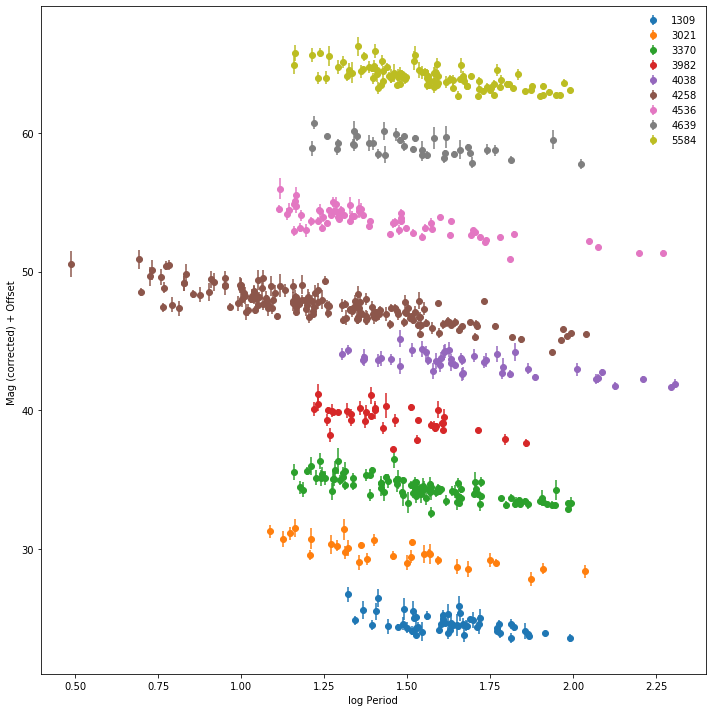

In [4]:
%matplotlib inline
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

for i, ID in enumerate(hosts):
    ceph.select(ID)
    mobs = ceph.mobs
    logP = ceph.logP
    sigma_obs = ceph.sigma
    ax.errorbar(logP, mobs+(5*i), yerr=sigma_obs, linestyle='None', marker='o', label=ID)
    
ax.legend(frameon=False)
ax.set_xlabel('log Period')
ax.set_ylabel('Mag (corrected) + Offset ')
fig.tight_layout()

# Q1.

## This data was taken from [Riess et al., 2011](https://arxiv.org/abs/1103.2976)

## The global model for the magnitudes of these Cepheids is given in Equation 1. You may ignore the effect of metalicity

## Some parameters (such as distance modulus) are specific to each galaxy.

## Others are common to all galaxies. 

## Assuming Gaussian magnitude errors and no period error (and you may ignore metallicity entirely), but that Cepheids scatter off the period-luminosity relation because of some Gaussian intrinsic dispersion $\sigma_{\text{int}}$, write down your expression for the likelihood being careful to use the same indices that Riess et. al used.


In [5]:
hosts

array(['1309', '3021', '3370', '3982', '4038', '4258', '4536', '4639',
       '5584'], dtype='<U21')

#### Note:
I fumbled quite a bit with this code. I tried my best to explain my rationale for most of what I ultimately implemented.

With that, I included an "appendix" of code that did not work out for me - for me to resource (I didn't want to delete everything in case I needed it again) and to investigate further if time allows. 

i.e. Everything after Q5 is just notekeeping.

### Magnitude (Eq1 from literature, ignoring metallicity): <br>
$m_{W,i,j} = (\mu_{0,i} − \mu_{0,4258}) + zp_{W,4258} + b_W \log(P_{i,j})$ 

### other possibly useful info from Riess:

"We determine the values of the nuisance parameters bW and ZW — which define the relation between Cepheid period, metallicity, and luminosity — by minimizing the χ2 for the global fit to all Cepheid data.."

"The reddening-free distances, μ0,i, for the hosts relative to NGC4258 are given by the fit parameters μ0,i −μ0,4258, while zp4258 is the intercept of the P–L relation simultaneously fit to the Cepheids of NGC 4258."

### Log likelihood from LEC 3 pt 2: <br>
$log L_{i,j} = -\frac{1}{2}\sum_{i,j} \log{2\pi\sigma_{int, i}^2} - \frac{1}{2} \sum_{i,j} \frac{(m^{\rm obs}_{i,j} - a_i\log{P_{i,j}} - b_i)^2}{\sigma_{int, i}^2}$

NOTE: I also noticed that the negative_log_likelihood function in cephieds.py gives you this value, however it excludes the term $\frac{1}{2}\sum_{i,j} \log{2\pi\sigma_{int, i}^2}$.

I'm not sure why this is, but I presume it just causes the log LL function to vary by a small factor. I compared the output of both my function and the cephieds.py method in Q1 below.

UPDATE: With further analysis I found the log_likelihood function I pulled from lec 3 gives me very different results for my trace plots and corner plots. Not clear to me why :( 

Therefore, I'm sticking with the cephieds.py version. Defined below.

### negative_log_likelihood from cephieds.py:

$ - log L_{i,j} = \frac{1}{2} \sum_{i,j} \frac{(m^{\rm obs}_{i,j} - a_i\log{P_{i,j}} - b_i)^2}{\sigma_{int, i}^2}$

where $a_i = b_W$ and $b_i = (\mu_{0,i} − \mu_{0,4258})$ + $zp_{W,4258}$

In [6]:
import numpy as np
import scipy.stats as st

#make a list of distance parameter values per host 
#e.g, (mu - mu4258) obtained from Table 3 of Riess, in order of hosts list below
#hosts = ['1309', '3021', '3370', '3982', '4038', '4258', '4536', '4639','5584']

d = [3.276, 3.138, 2.835, 2.475, 2.396, 0, 1.567, 2.383, 2.461]

# these parameters will vary for different host galaxies:
# for i,ID in enumerate(hosts):
#     ceph.select(ID)
#     d_params = d[i]
#     logP = ceph.logP
#     #b_w = slope of P vs L (from plots)
#     #zp_w = intercept of P-L relation (obtain from plots)
    
#make a model for magnitudes using Riess params

def modelmag(a, b, logP):
    mag = a*logP + b
    return mag

#likelihood expression from lecture
def log_likelihood(a, b, sigma, logP, mobs):
    model = modelmag(a, b, logP)
    return -0.5*np.sum(np.log10((2*np.pi*sigma**2))) - 0.5*np.sum((mobs - model)**2/(sigma**2))

In [7]:
#testing for one galaxy/host
ceph.select(1309)
mobs = ceph.mobs
sig = ceph.sigma
logP = ceph.logP

slope, intercept, r_value, p_value, std_err = st.linregress(logP,mobs)
a = slope
b = intercept

log_likelihood(a, b, sig, logP, mobs)

-66.59052881891945

In [8]:
#i want to compare my function with that of the function in the cephieds.py script

ceph.select(1309)
mobs = ceph.mobs
sig = ceph.sigma
logP = ceph.logP

slope, intercept, r_value, p_value, std_err = st.linregress(logP,mobs)
a = slope
b = intercept
theta = a,b

ceph.negative_log_likelihood(theta)

68.74867540176336

Hm, this is almost right (negative of my own log_likelihood value). 

For safety/my sanity, I will just implement the likelihood function from cephieds.py for the remainder of my code.

# Q2. 

## Given what you know for each of the parameters in this model, write down physically motivated (i.e. not just top hats on everything) priors, along with your explanation.

## Think particularly about the priors for distances to each galaxy.

In [9]:
#i want to see all the slope and intercept values of the real data
for i,ID in enumerate(hosts):
    ceph.select(ID)
    mobs = ceph.mobs
    logP = ceph.logP
    slope, intercept, r_value, p_value, std_err = st.linregress(logP,mobs)
    print(slope, intercept)

-2.514378739681139 28.73937944274379
-3.2154398110544853 29.479613563630934
-2.8637073481235467 28.808904848575427
-3.291386790149582 29.170444720557704
-2.3480237789255574 27.373591716441652
-3.285168895685577 26.716415320609368
-3.045968516120309 27.97127357180916
-1.8780931989455245 26.923482130399307
-2.857143788606277 28.49368089263738


Given the data, the ranges for each of the parameters should be approximately the following:
### Priors
using $a = b_W$ = slope <br>
and $b = (\mu_{0,i} − \mu_{0,4258}) + zp_{W,4258}$  = intercept <br>

$-3.3 \leq a \leq -2.9$ <br>
$25 \leq b \leq 30$ <br>

# Q3. 

## Implement this likelihood and prior in python and sample the posterior distribution with emcee.

## Construct traceplots for each parameter, as well as corner plots for each pair of parameters.


## If your Markov Chains are reasonable, verify that your model fits are reasonable by reconstructing Fig. 7 of Riess et al. 2011

## Compare the intercept you find for the intercepts $\mu_{0,i} - \mu_{0, 4258}$ vs Table 3 of Riess et al. 2011

In [10]:
import scipy.optimize as so
import emcee
import corner
import pandas as pd

In [11]:
#the priors
def log_prior(a, b):
    #using loose bounds
        if -5 < a < 0 and 20 < b < 30:
            return 0.0
        return -np.inf

100%|██████████| 5000/5000 [00:15<00:00, 316.42it/s]


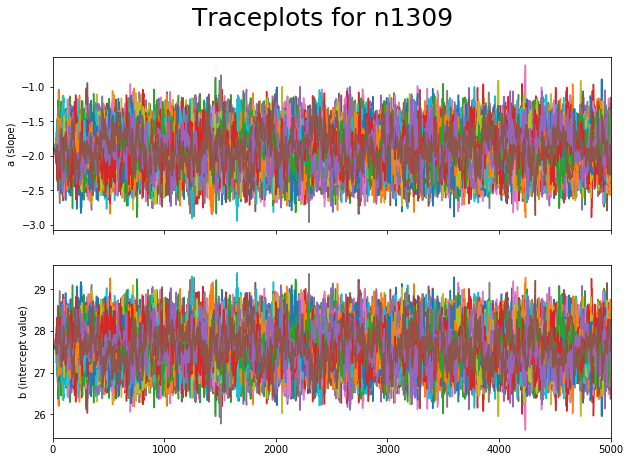

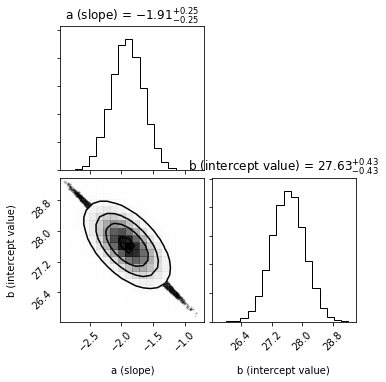

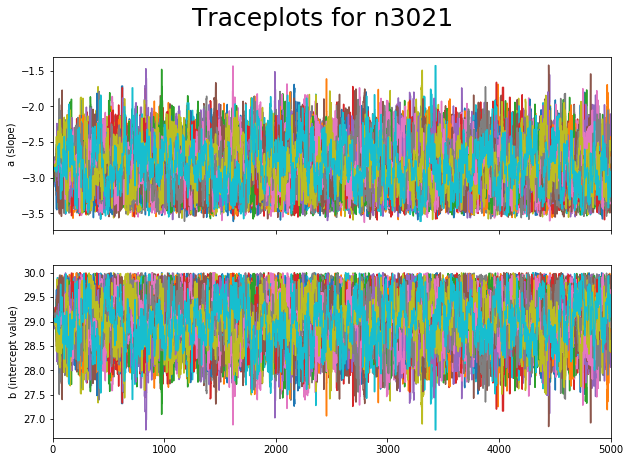

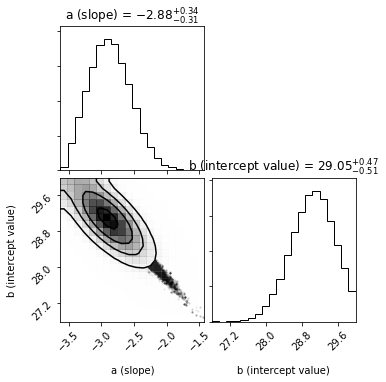

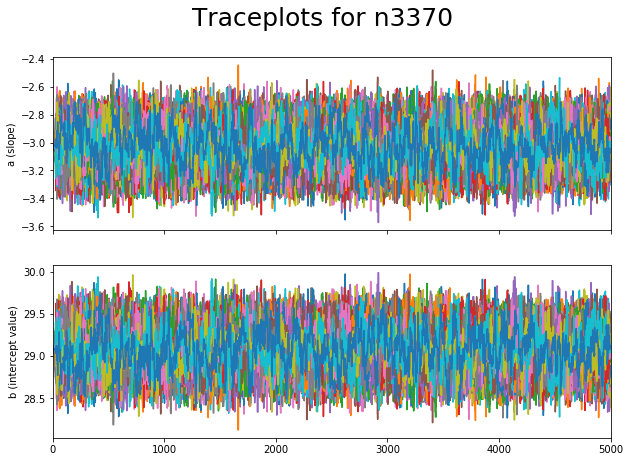

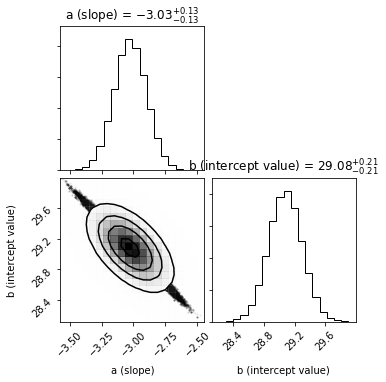

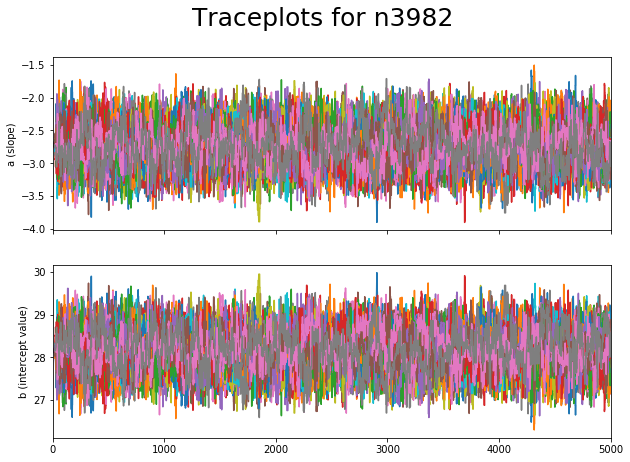

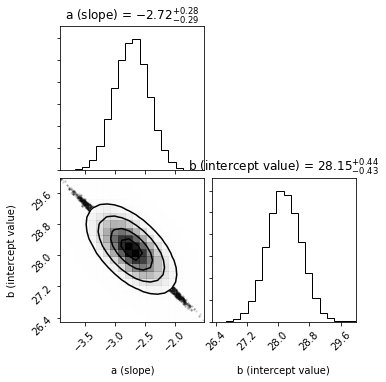

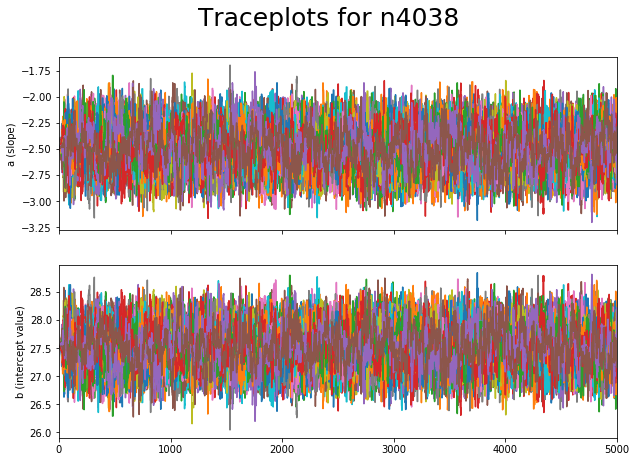

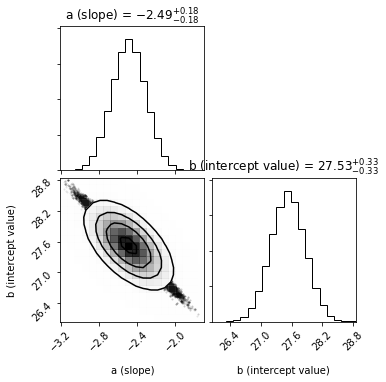

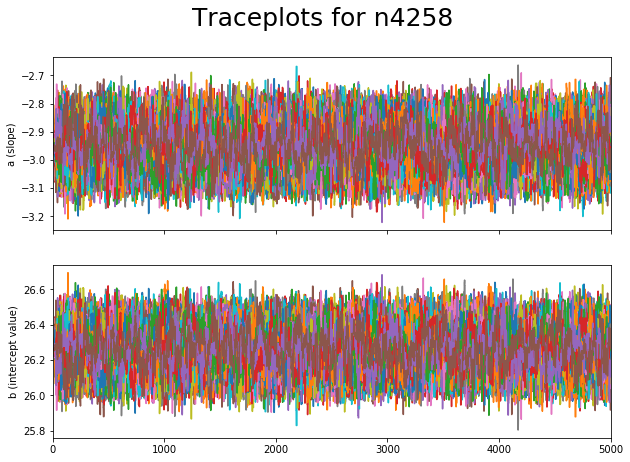

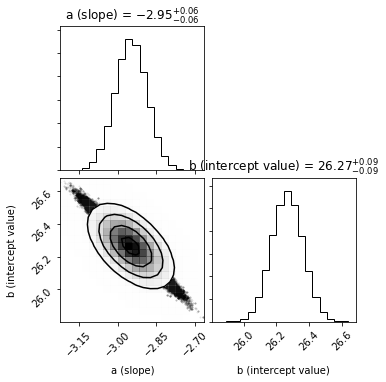

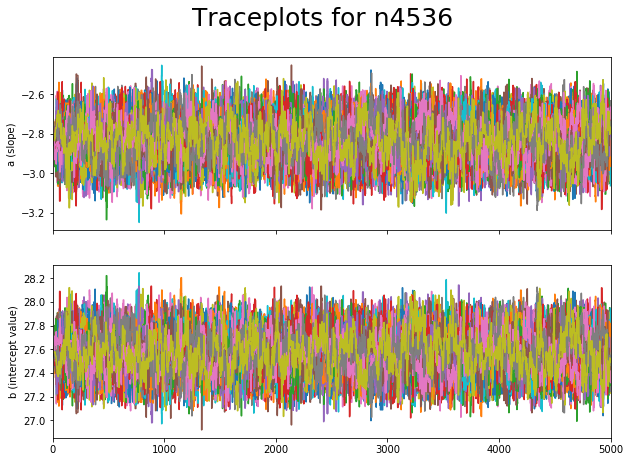

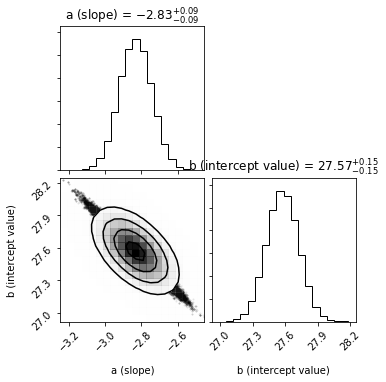

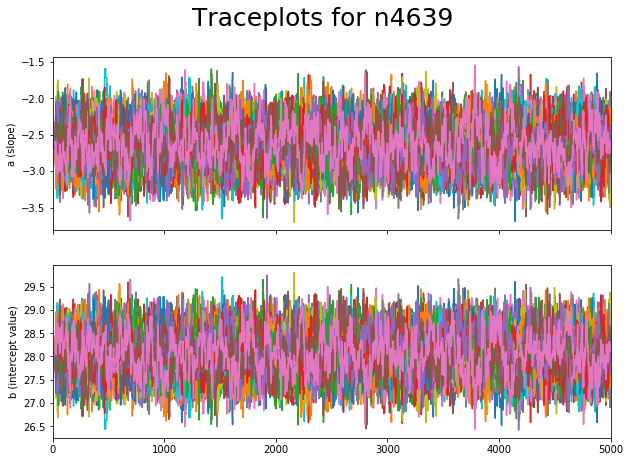

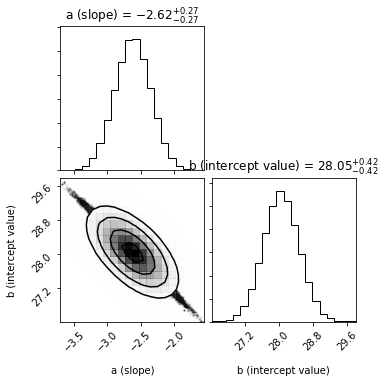

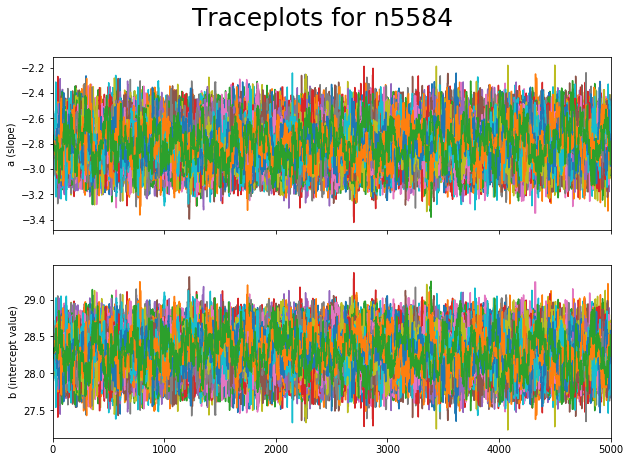

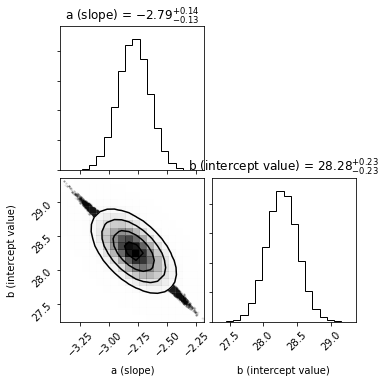

In [15]:
for i,ID in enumerate(hosts):
    
    ceph.select(ID)
    mobs = ceph.mobs
    sig = ceph.sigma
    logP = ceph.logP
    slope, intercept, r_value, p_value, std_err = st.linregress(logP,mobs)
    a = slope
    b = intercept
    theta = a,b
    
    #optimization
    negLL = ceph.negative_log_likelihood
    bounds = [(-5,0), (20,30)]
    init = [-3.5, 50]
    args = (sig, mobs, logP)

    res = so.minimize(ceph.negative_log_likelihood, init, bounds=bounds)
    a_max, b_max = res.x
        
    #Posterior probability
    def post_prob(theta, sig, mobs, logP):
        a, b = theta
        lnlike = -ceph.negative_log_likelihood(theta)
        lnprior = log_prior(a, b)
        lnposterior = lnlike + lnprior
        return lnposterior
    
    pos = res.x + 1e-4*np.random.randn(len(mobs), 2)
    nwalkers, ndim = pos.shape
    
    samp = emcee.EnsembleSampler(nwalkers, ndim, post_prob, args = args)
    samp.run_mcmc(pos, 5000, progress = True)
    
    #figure for traceplots
    fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
    samples = samp.get_chain()
    labels = ["a (slope)", "b (intercept value)"]
    fig.suptitle("Traceplots for n{}".format(hosts[i]), size = 25)
    
    for i in range(ndim):
        ax = axes[i]
        ax.plot(samples[:,:,i])
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[i])
    
    
    #remove possible burnin
    trimmed = samp.get_chain(discard = 250, flat = True)
    
    figcorner = corner.corner(trimmed, plot_contours = True, show_titles = True, smooth = 2, labels = labels)
       

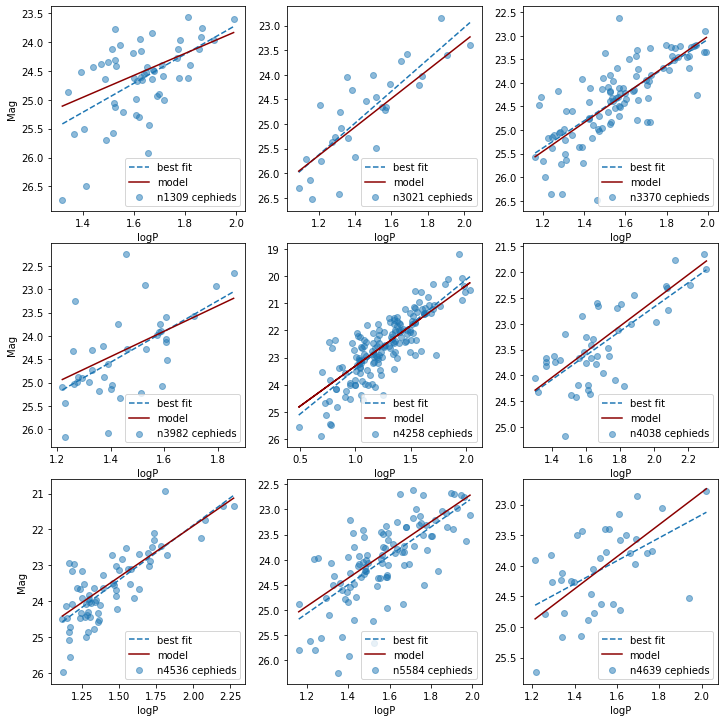

In [16]:
#figure for recreating Riess plot
fig2, axes2 = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
fig2.tight_layout()

#a and b values from cornerplots
a_samp = [-1.90, -2.88, -3.03, -2.72, -2.49, -2.95, -2.84, -2.63, -2.79]
b_samp = [27.62, 29.09, 29.08, 28.25, 27.53, 26.26, 27.58, 28.06, 28.27]

for i,ID in enumerate(hosts):
    ceph.select(ID)
    
    logP = ceph.logP
    mobs = ceph.mobs
    
    a = a_samp[i]
    b = b_samp[i]
    
    mag_samp = modelmag(a,b,logP)
   
    if i <= 2:
        axes2[0,i].plot(np.unique(logP), 
                        np.poly1d(np.polyfit(logP, mobs, 1))(np.unique(logP)), 
                        ls = '--', label = "best fit")
        axes2[0,i].plot(logP, mag_samp, label = "model", c = 'darkred')
        axes2[0,i].scatter(logP, mobs, label = "n{} cephieds".format(hosts[i]), alpha =.5)
        axes2[0,i].invert_yaxis()        
        axes2[0,i].set_xlabel("logP")
        axes2[0,0].set_ylabel("Mag")
        axes2[0,i].legend(loc = "lower right")
    
        
    if 2 < i <= 5:
        axes2[1,3-i].plot(np.unique(logP), 
                          np.poly1d(np.polyfit(logP, mobs, 1))(np.unique(logP)), 
                          ls = '--', label = "best fit")
        axes2[1,3-i].plot(logP, mag_samp, label = "model", c='darkred')
        axes2[1,3-i].scatter(logP, mobs, label = "n{} cephieds".format(hosts[i]), alpha = .5)
        axes2[1,3-i].invert_yaxis()
        axes2[1,3-i].set_xlabel("logP")
        axes2[1,0].set_ylabel("Mag")
        axes2[1,3-i].legend(loc = "lower right")
        
    if 5 < i:
        axes2[2,6-i].plot(np.unique(logP), 
                          np.poly1d(np.polyfit(logP, mobs, 1))(np.unique(logP)), 
                          ls = '--', label = "best fit")
        axes2[2,6-i].plot(logP, mag_samp, label = "model", c = 'darkred')
        axes2[2,6-i].scatter(logP, mobs, label = "n{} cephieds".format(hosts[i]), alpha = .5)
        axes2[2,6-i].invert_yaxis()
        axes2[2,6-i].set_xlabel("logP")
        axes2[2,0].set_ylabel("Mag")
        axes2[2,6-i].legend(loc = 'lower right')

In [35]:
percentdiff = ((np.array(b_samp) - np.array(d))/np.array(b_samp))*100

data = {'Host': hosts,'Model Dist Params':b_samp, 'True Dist Params':d, 'Percent Difference':percentdiff}

df = pd.DataFrame(data)
df

,Host,Model Dist Params,True Dist Params,Percent Difference
0,1309,27.62,3.276,88.139030
1,3021,29.09,3.138,89.212788
2,3370,29.08,2.835,90.251032
3,3982,28.25,2.475,91.238938
4,4038,27.53,2.396,91.296767
5,4258,26.26,0.000,100.000000
6,4536,27.58,1.567,94.318347
7,4639,28.06,2.383,91.507484
8,5584,28.27,2.461,91.294659


Ok so these are very different and my intuition tells me that the missing factor between the distances is the $zp_W,4258$ term that is part of the magnitude equation.

The literature mentions that the z variable is a nuisance parameter that depends on metallicity and its relationship with a couple of other factors. (We ignored metallicity so that might have something to do with this discrepancy).

I could at least guesstimate that this value $zp_{W,4258}$ is around 26.26 for host galaxy n4258 given that distances were measured with respect to this host.

Otherwise, I dont know how to calculate legitimate values for $zp_{W,4258}$ and cannot find the parameters in the paper.

# Q4.

## Riess et al. do a *simultaneous* fit to the Cepheids and SNe data (Table 3 of their paper). 

## I'm slightly less cruel, so you can take your intercepts $\mu_{0,i} - \mu_{0, 4258}$ and the re-express equation 4 using a substitution of equation 3.

## Write that expression down.

### From Riess:

$logH_0 = \frac{m_{v,4258}-\mu_{0,4258} + 5a_v + 25}{5}$

### Eq  3 gives:

$m_{v,4258}-\mu_{0,4258} = m_{v,i} - \mu_{0,i}$ <br>

$logH_0 = \frac{m_{v,4258}-\mu_{0,4258} + 5a_v + 25}{5}$

### Final expression:
$logH_0 = \frac{m_{v,i} + 5a_v + 25 - (\mu_{0,i} - \mu_{0,4258}) - \mu_{0,4258}}{5}$

# Q5

## Using the supernova data in Table 3 (enter it into whatever data structure you deem best) and the distance modulus to NGC 4258 from [Humphreys et al., 2013 ](https://ui.adsabs.harvard.edu/abs/2013ApJ...775...13H/abstract) and using the simple sample statistics you learned in Week 1, estimate the Hubble constant.

In [47]:
#from Humphreys

d4258 = 7.60*1e6 #parsecs

host = ['n4536', 'n4639', 'n3370', 'n3982', 'n3021', 'n1309', 'n5584', 'n4038']
SNIa = ['1981B', '1990N', '1994ae', '1998aq', '1995al', '2002fk', '2007af', '2007sr']
magp5 = [15.147, 16.040, 16.545, 15.953, 16.699, 16.768, 16.274, 15.901]
mudiff = [1.567, 2.383, 2.835, 2.475, 3.138, 3.276, 2.461, 2.396]

SNdata = {'m + 5av': magp5, 'D param': mudiff}

SNdf = pd.DataFrame(SNdata)

SNdf   

,m + 5av,D param
0,15.147,1.567
1,16.040,2.383
2,16.545,2.835
3,15.953,2.475
4,16.699,3.138
5,16.768,3.276
6,16.274,2.461
7,15.901,2.396


In [71]:
def H0(mp5, dp, distmod):
    mu4258 = 5*np.log10(distmod) - 5
    return(0.2*(mp5 + 25 - dp - mu4258))

Hdf = H0(SNdf['m + 5av'], SNdf['D param'], d4258)

mean = Hdf.mean(axis=0)
err = Hdf.std(axis=0)

print( r'H0 = {} ± {}'.format(mean,err))

H0 = 1.8390864077192095 ± 0.0236896601917377


# End of Midterm Responses

### Coding Graveyard:

100%|██████████| 5000/5000 [00:25<00:00, 195.57it/s]


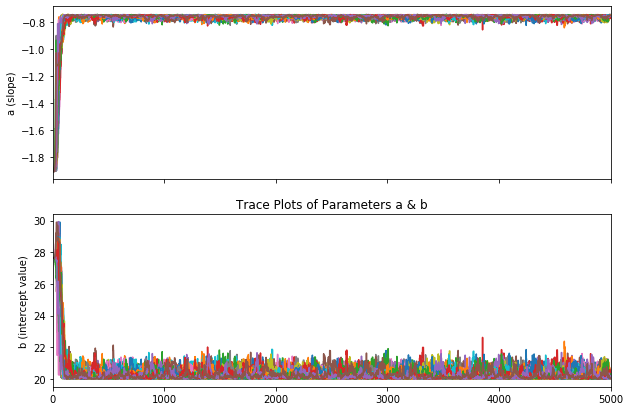

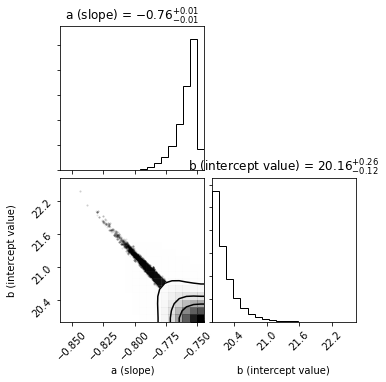

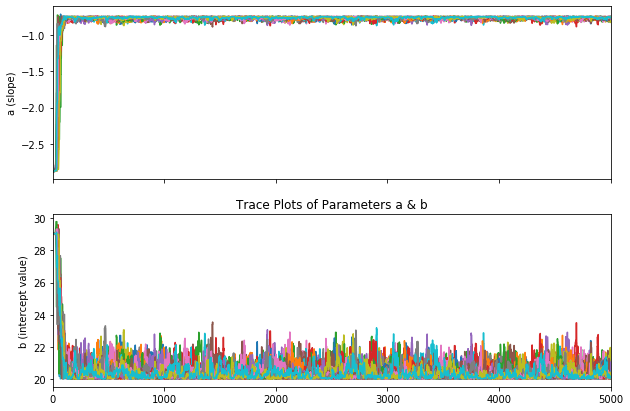

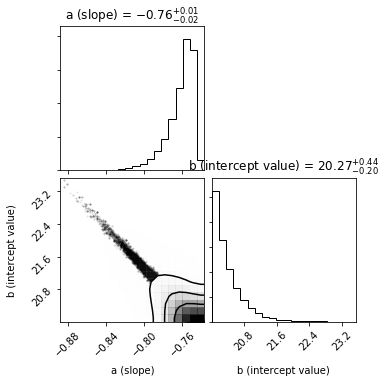

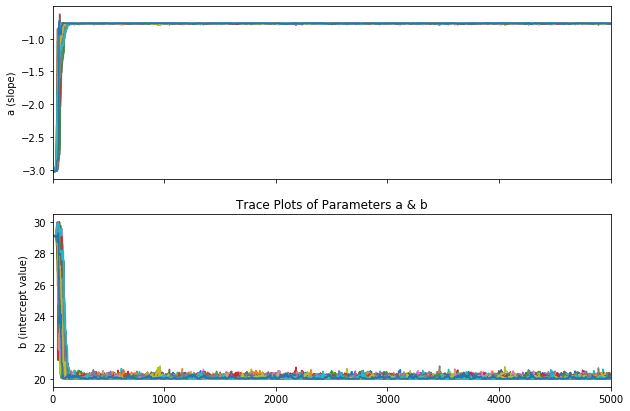

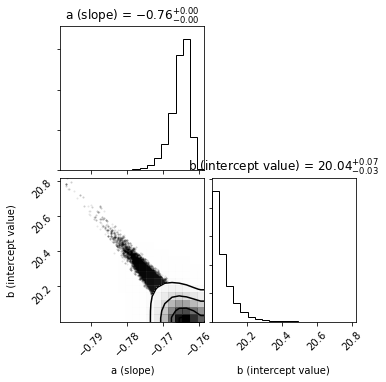

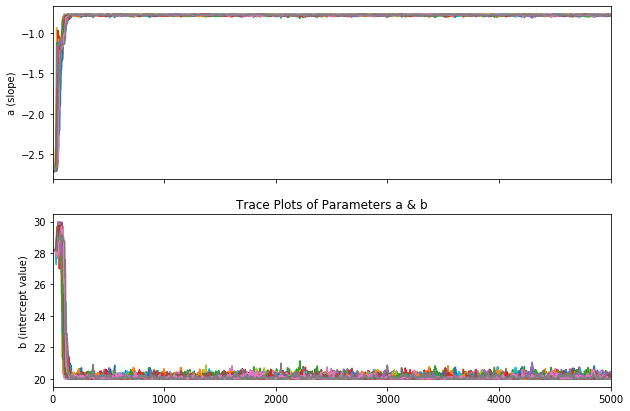

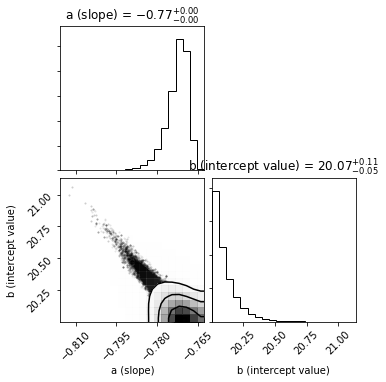

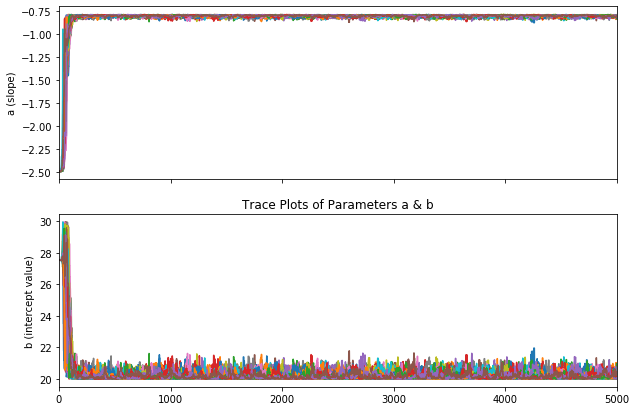

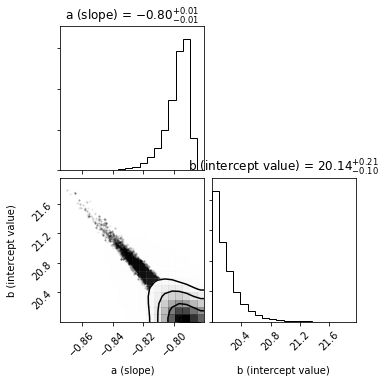

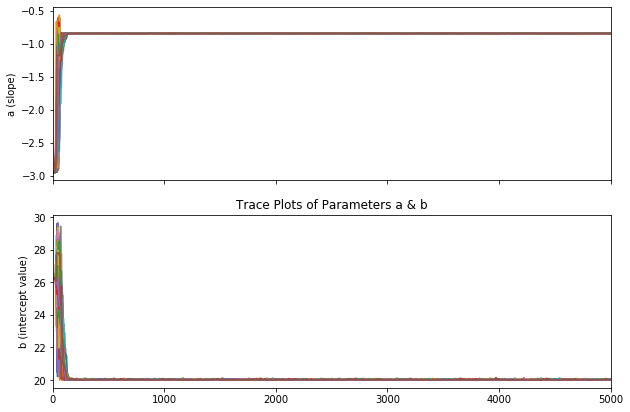

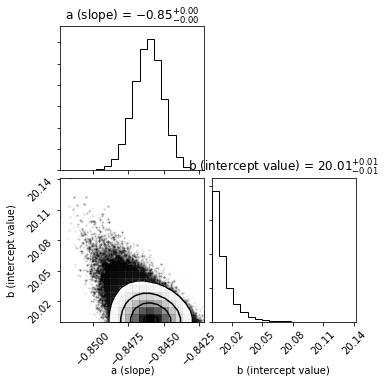

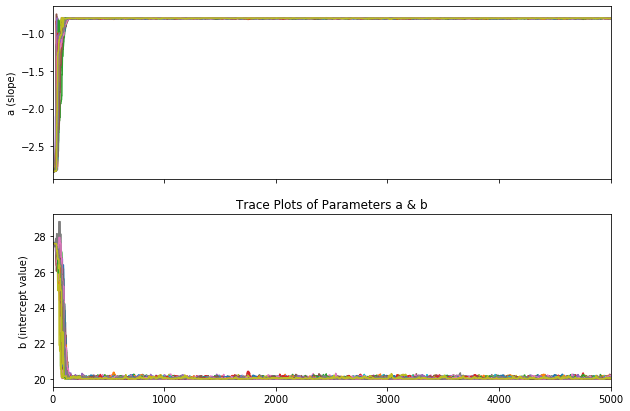

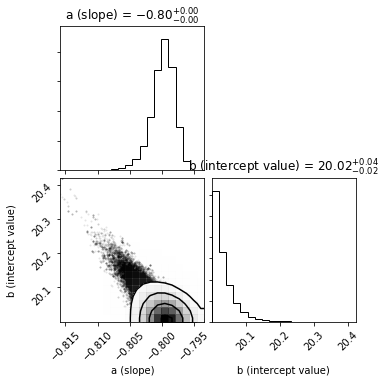

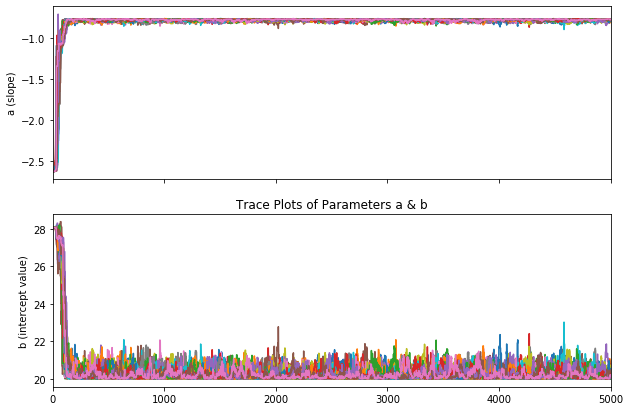

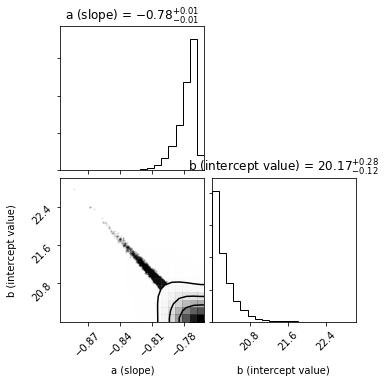

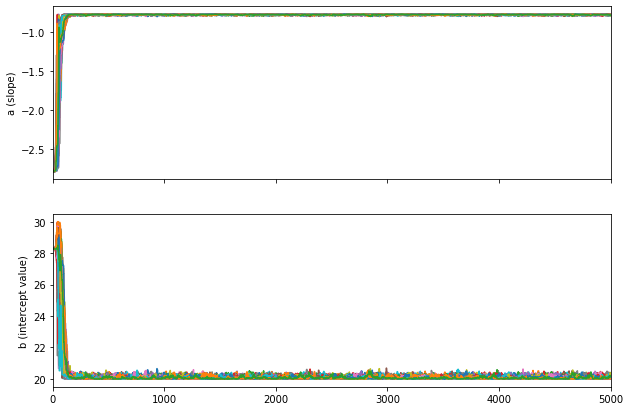

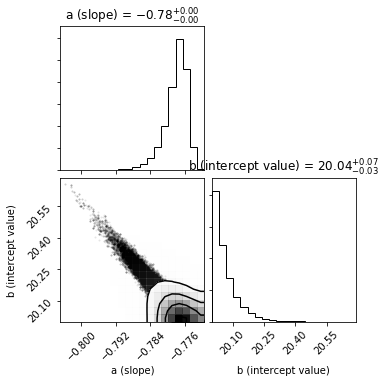

In [72]:
for i,ID in enumerate(hosts):
    
    ceph.select(ID)
    mobs = ceph.mobs
    sig = ceph.sigma
    logP = ceph.logP
    slope, intercept, r_value, p_value, std_err = st.linregress(logP,mobs)
    a = slope
    b = intercept
    
    def chisq(x, *args):
        a, b = x
        sig, mobs, logP = args
        mod = modelmag(a,b,logP)
        chisq = np.sum( ((mobs-mod)**2)/sig**2 )
        return chisq
    
    bounds = [(-5,0), (20,30)]
    init = [-3.5, 50]
    args = (sig, mobs, logP)

    res = so.minimize(chisq, init, args=args, bounds = bounds)
    a_max, b_max = res.x
        
    def post_prob(theta, sig, mobs, logP):
        a, b = theta
        lnlike = log_likelihood(a, b, sig, mobs, logP)
        lnprior = log_prior(a, b)
        lnposterior = lnlike + lnprior
        return lnposterior
    
    pos = res.x + 1e-4*np.random.randn(len(mobs), 2)
    nwalkers, ndim = pos.shape
    
    samp = emcee.EnsembleSampler(nwalkers, ndim, post_prob, args = args)
    samp.run_mcmc(pos, 5000, progress = True)
    
    fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
    samples = samp.get_chain()
    labels = ["a (slope)", "b (intercept value)"]
    ax.set_title("Trace Plots of Parameters a & b")
    
    #print(samples)
    
    for i in range(ndim):
        ax = axes[i]
        ax.plot(samples[:,:,i])
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[i])
    
    
    trimmed = samp.get_chain(discard = 250, flat = True)
    fig = corner.corner(trimmed, plot_contours = True, show_titles = True, smooth = 2, labels = labels)

## Comments

### Traceplots

Each traceplot varies over a large range for the first couple hundred steps or so then oscillates over a much smaller range thereafter. I think is the "burn-in" but I'm not certain. 

I feel like the effect should have been the opposite - values should oscillate over a small range in the beginning and then expand to the full allowed range after the first small fraction of steps..

I can't quite figure out why the sampling is doing this. I've modified the bounds but recover the same effect. At this point I suspect it's an error with my prior function or the way I set up my minimize function.

I proceeded for now, discarding the first 5 percent of steps for my corner plots.

### Corner Plots

It's very evident that my values for a (slope) are sweked right, indicating that the majority of values making up the sample are larger than what was anticipated. This is going to make my sample data have flatter slopes that are not representative of the actual data (I think). Moreover, the values for b (y-intercepts) are skewed toward small values.

Again, I know these results are off, but cannot pinpoint the exact location of error at the moment.

## Update:

It had to do with the log_likelihood function I tried to implement. Ending up using negative_log_likelihood from cephieds.py